# 17634 Applied Machine Learning - HW2 - Zillow Zestmate Prediction
### Author: Yi-Hsueh Yang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

## 1. Read in Data

In [3]:
with open('data/merged_data.csv', 'rb') as f:
    result = chardet.detect(f.read())

zillow = pd.read_csv("data/merged_data.csv", encoding=result['encoding'])
zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111000e+13,0.0953,1/27/16
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111000e+13,0.0198,3/30/16
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111000e+13,0.0060,5/27/16
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,...,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111000e+13,-0.0566,6/7/16
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,...,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111000e+13,0.0573,8/8/16


## Data Cleaning

In [138]:
df = zillow.copy()

### Starts to deal with Missing Values

In [139]:
df.isnull().sum()

parcelid                             0
airconditioningtypeid           114100
architecturalstyletypeid        167420
basementsqft                    167795
bathroomcnt                         34
bedroomcnt                          34
buildingclasstypeid             167857
buildingqualitytypeid            60715
calculatedbathnbr                 1832
decktypeid                      166616
finishedfloor1squarefeet        154995
calculatedfinishedsquarefeet       896
finishedsquarefeet12              8369
finishedsquarefeet13            167813
finishedsquarefeet15            161297
finishedsquarefeet50            154995
finishedsquarefeet6             167081
fips                                34
fireplacecnt                    149992
fullbathcnt                       1832
garagecarcnt                    112431
garagetotalsqft                 112431
hashottuborspa                  163984
heatingorsystemtypeid            62237
latitude                            34
longitude                

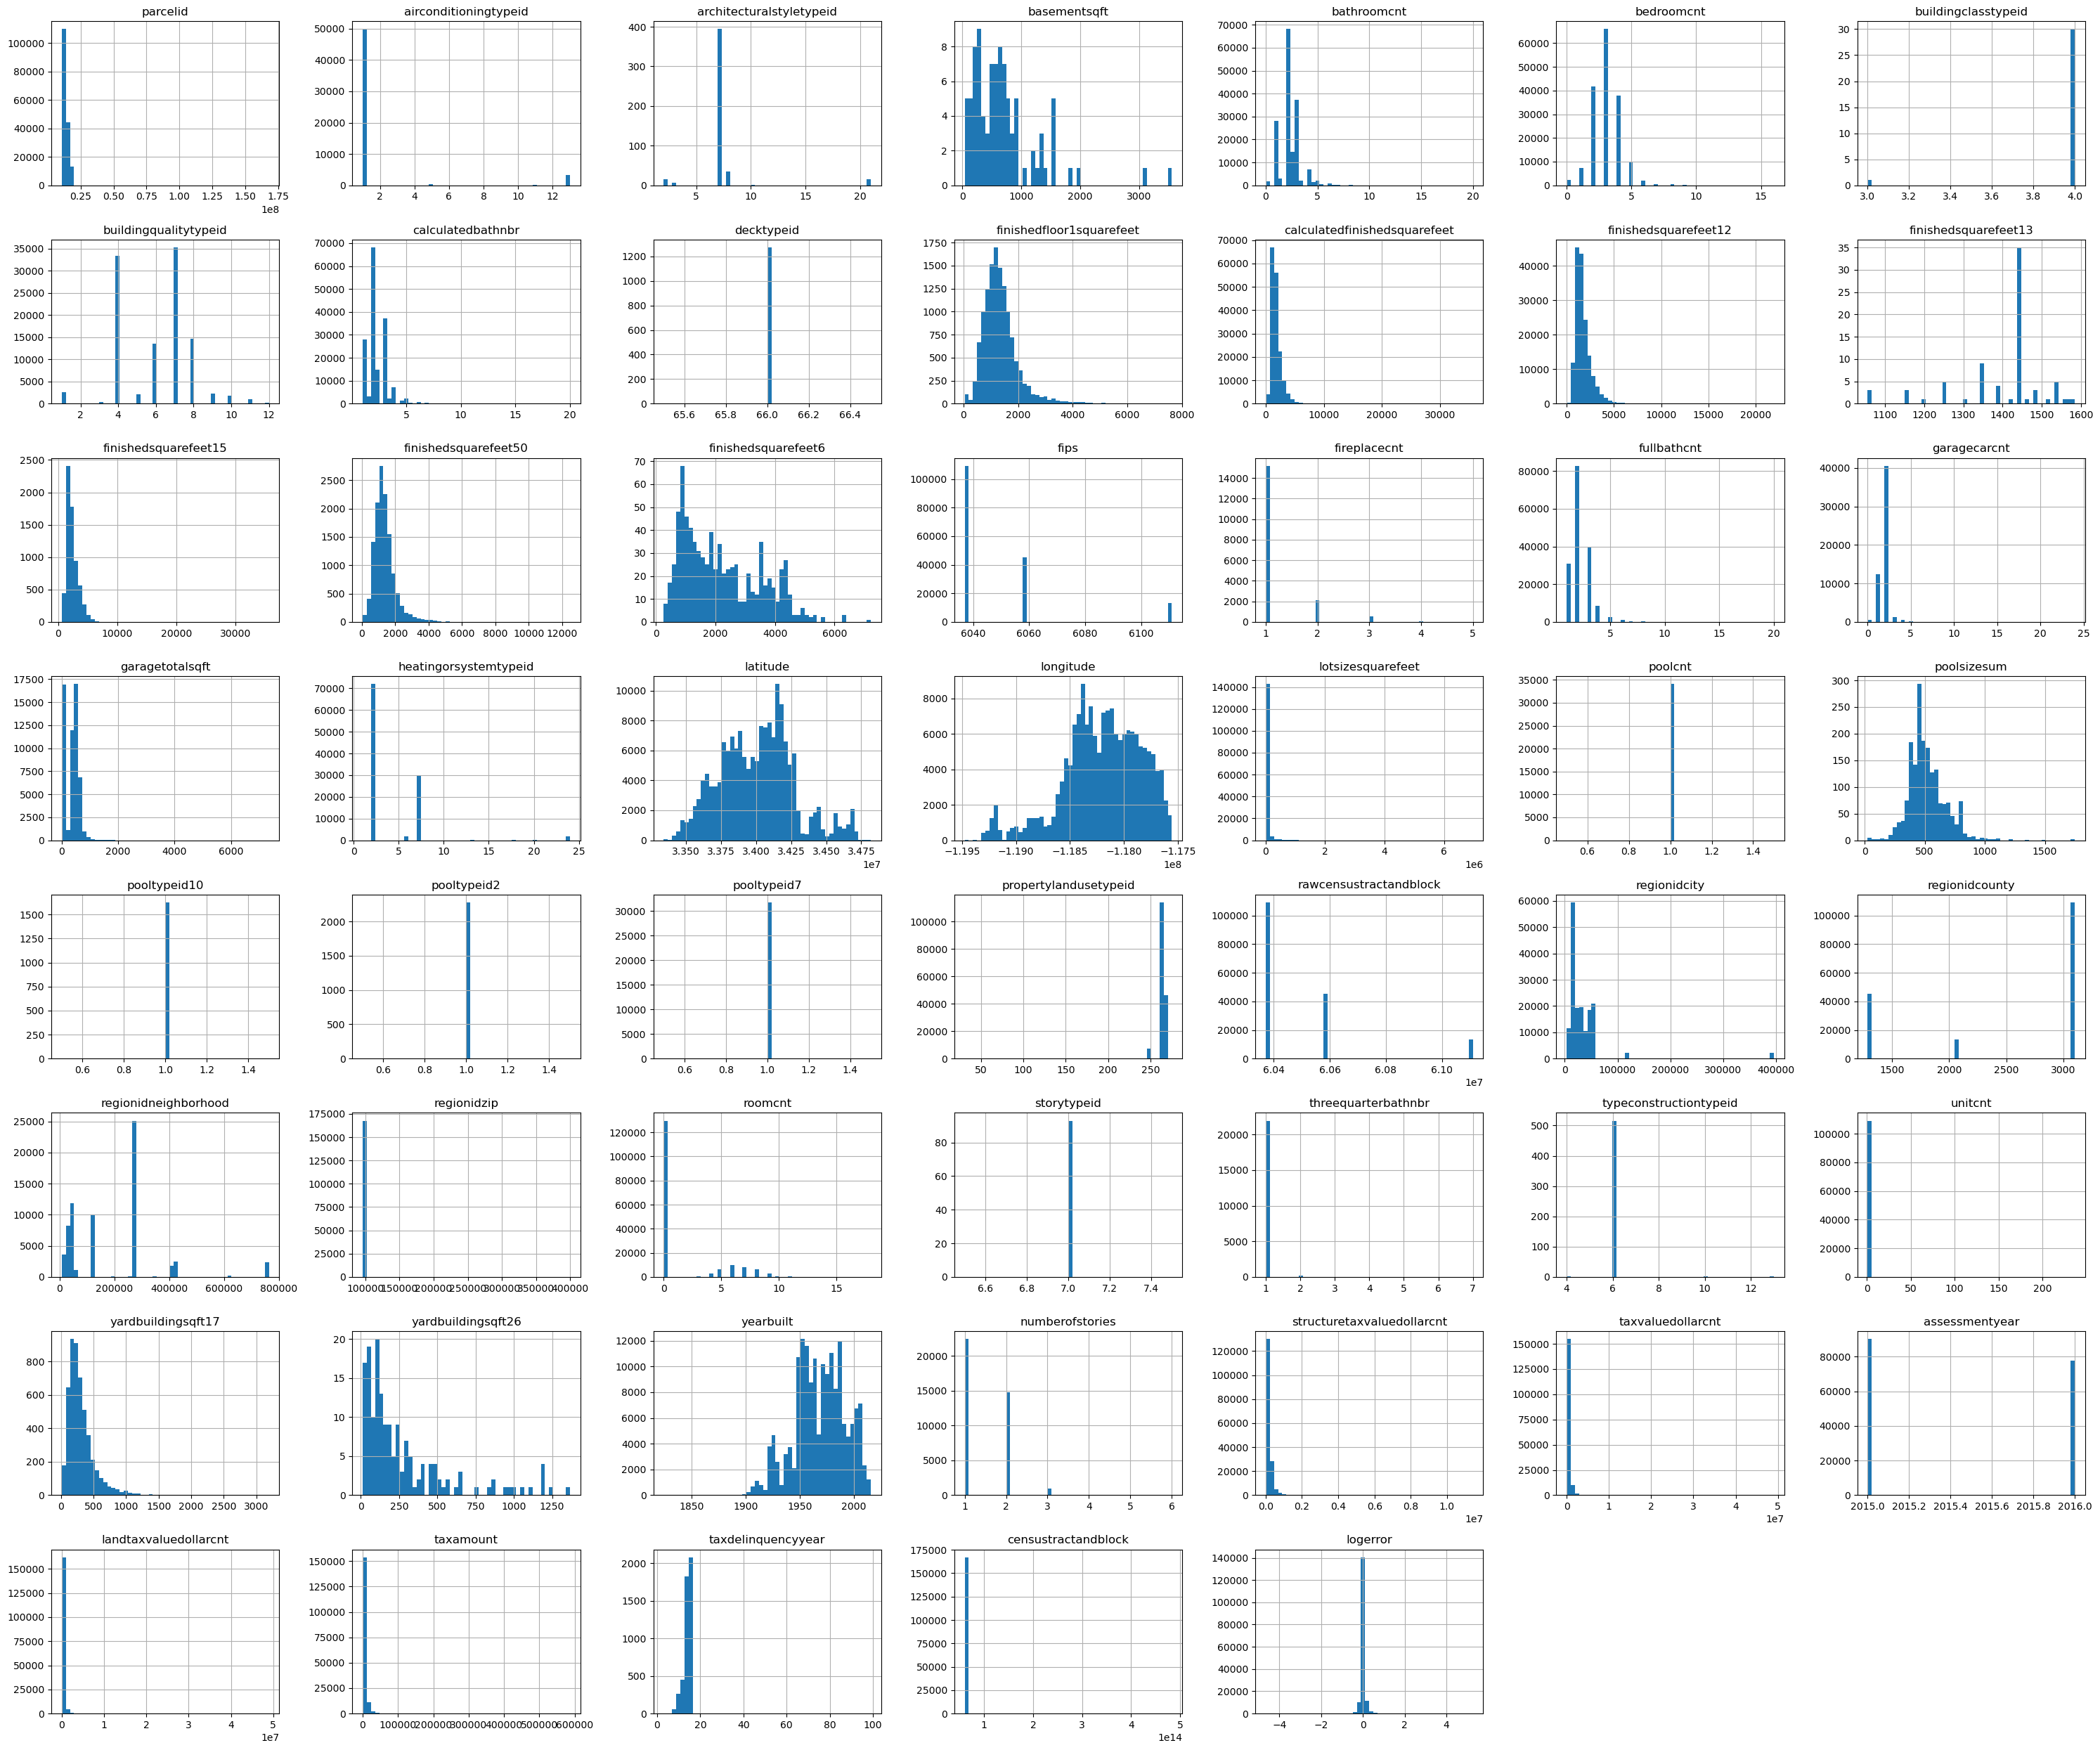

In [140]:
df.hist(bins=50, figsize=(30,25))
plt.tight_layout()

### Main Objective: to estimate the lowest log error

In [141]:
df[['poolcnt','basementsqft','decktypeid', 'pooltypeid10', 'storytypeid','architecturalstyletypeid',
'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26']].describe()

,poolcnt,basementsqft,decktypeid,pooltypeid10,storytypeid,architecturalstyletypeid,typeconstructiontypeid,yardbuildingsqft17,yardbuildingsqft26
count,34075.0,93.000000,1272.0,1626.0,93.0,468.000000,522.000000,5039.000000,165.000000
mean,1.0,695.376344,66.0,1.0,7.0,7.299145,6.022989,307.919032,271.260606
std,0.0,583.952144,0.0,0.0,0.0,2.719633,0.491236,227.430960,293.611447
min,1.0,38.000000,66.0,1.0,7.0,2.000000,4.000000,11.000000,12.000000
25%,1.0,280.000000,66.0,1.0,7.0,7.000000,6.000000,175.000000,88.000000
50%,1.0,588.000000,66.0,1.0,7.0,7.000000,6.000000,252.000000,160.000000
75%,1.0,819.000000,66.0,1.0,7.0,7.000000,6.000000,375.000000,320.000000
max,1.0,3560.000000,66.0,1.0,7.0,21.000000,13.000000,3191.000000,1366.000000


In [142]:
col_filling_0 = ['poolcnt','decktypeid','basementsqft','yardbuildingsqft26','yardbuildingsqft17','storytypeid','fireplacecnt',
'finishedfloor1squarefeet','finishedsquarefeet50','garagetotalsqft','garagecarcnt','taxdelinquencyflag']

df.loc[:, col_filling_0] = df.loc[:, col_filling_0].fillna(value=0)

df['hashottuborspa'].fillna(value=False, inplace=True)
df.loc[:, ['typeconstructiontypeid', 'architecturalstyletypeid']].fillna(value={'typeconstructiontypeid': 14, 'architecturalstyletypeid': 19}, inplace=True)

# Due to the high correlation and the information they provide are similar to 'finishedsquarefeet50', it is likely that they are having
# high collinearity with each other which is not good for training model, thus drop them. 
df.drop(['calculatedfinishedsquarefeet','finishedsquarefeet6', 'finishedsquarefeet13', 'finishedsquarefeet12'], axis=1, inplace=True)

# Combine two similar columns to a new column and drop the original two
df[['pooltypeid2', 'pooltypeid7']].fillna(0, inplace=True)

df['pool_with_tub'] = df['pooltypeid2'].apply(lambda x: 1 if x == 1 else 0) + df['pooltypeid7'].apply(lambda x: -1 if x == 1 else 0)

# Drop the original columns, pooltypeid7 is also a column about spa or hot tub, 
# i think the existence of spas or tubs matter but not the type of it, so i choose to drop it.
df.drop(['pooltypeid2', 'pooltypeid7', 'pooltypeid10'], axis=1, inplace=True)

In [148]:
# Fill in NAs based on the median of each features.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
col_to_impute = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fips', 'fullbathcnt', 'propertylandusetypeid', 'roomcnt', 
                'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet']
df_to_impute = df[col_to_impute]
imputer.fit(df_to_impute)
df_imputed = imputer.transform(df_to_impute)
df[col_to_impute] = df_imputed

In [149]:
# Fill missing values with the most frequent value
df['propertycountylandusecode'].fillna(value=df['propertycountylandusecode'].mode().values[0], inplace=True)
df['regionidcity'].fillna(value=df['regionidcity'].mode().values[0], inplace=True)
df['regionidcounty'].fillna(value=df['regionidcounty'].mode().values[0], inplace=True)
df['regionidzip'].fillna(value=df['regionidzip'].mode().values[0], inplace=True)
df['rawcensustractandblock'].fillna(value=df['rawcensustractandblock'].mode().values[0], inplace=True)
df['censustractandblock'].fillna(value=df['censustractandblock'].mode().values[0], inplace=True)

In [151]:
# Fill in NAs based on the original proportion of each categories.
col_fill_proportions = ['heatingorsystemtypeid','buildingqualitytypeid','buildingclasstypeid','airconditioningtypeid','unitcnt','propertyzoningdesc','regionidneighborhood']

for col in col_fill_proportions:
    # Calculate the proportions for each category
    total = df[col].count()
    proportions = df[col].value_counts() / total

    # Create a dictionary that maps the categories to their proportions
    proportions_dict = dict(zip(proportions.index, proportions.values))

    # Fill missing values in the column based on the proportions
    df[col] = df[col].apply(lambda x: np.random.choice(list(proportions_dict.keys()), p=list(proportions_dict.values())) if pd.isna(x) else x)

In [153]:
#dropping columns with more than 99% of missing value
df.drop(columns=['architecturalstyletypeid', 'basementsqft', 'decktypeid', 'storytypeid', 
'typeconstructiontypeid', 'yardbuildingsqft26', 'fireplaceflag'], axis=1, inplace=True)

In [154]:
# Perform KNN imputation of longitude, latitude, and assessmentyear, all of them have a missing value less than 1%
from sklearn.impute import KNNImputer

col_to_knnimpute = ['longitude','latitude','assessmentyear','finishedsquarefeet15','poolsizesum','threequarterbathnbr','numberofstories','taxdelinquencyyear']
imputer = KNNImputer(n_neighbors=3)

df[col_to_knnimpute] = imputer.fit_transform(df[col_to_knnimpute])

encoding_dict = {True: '1', False: '0'}
df['taxdelinquencyflag'] = df['taxdelinquencyflag'].replace(encoding_dict)

In [157]:
df['fips'] = df['fips'].astype('category')
df['propertycountylandusecode'] = df['propertycountylandusecode'].astype('category')
df['propertylandusetypeid'] = df['propertylandusetypeid'].astype('category')
df['propertyzoningdesc'] = df['propertyzoningdesc'].astype('category')
df['rawcensustractandblock'] = df['rawcensustractandblock'].astype('category')
df['regionidcity'] = df['regionidcity'].astype('category')
df['regionidneighborhood'] = df['regionidneighborhood'].astype('category')
df['regionidzip'] = df['regionidzip'].astype('category')
df['censustractandblock'] = df['censustractandblock'].astype('category')

In [ ]:
corr_matrix = df.corr()
corr_matrix["logerror"].sort_values(ascending=False)

In [169]:
df.to_csv('cleaned_data.csv')

## Data Visualization

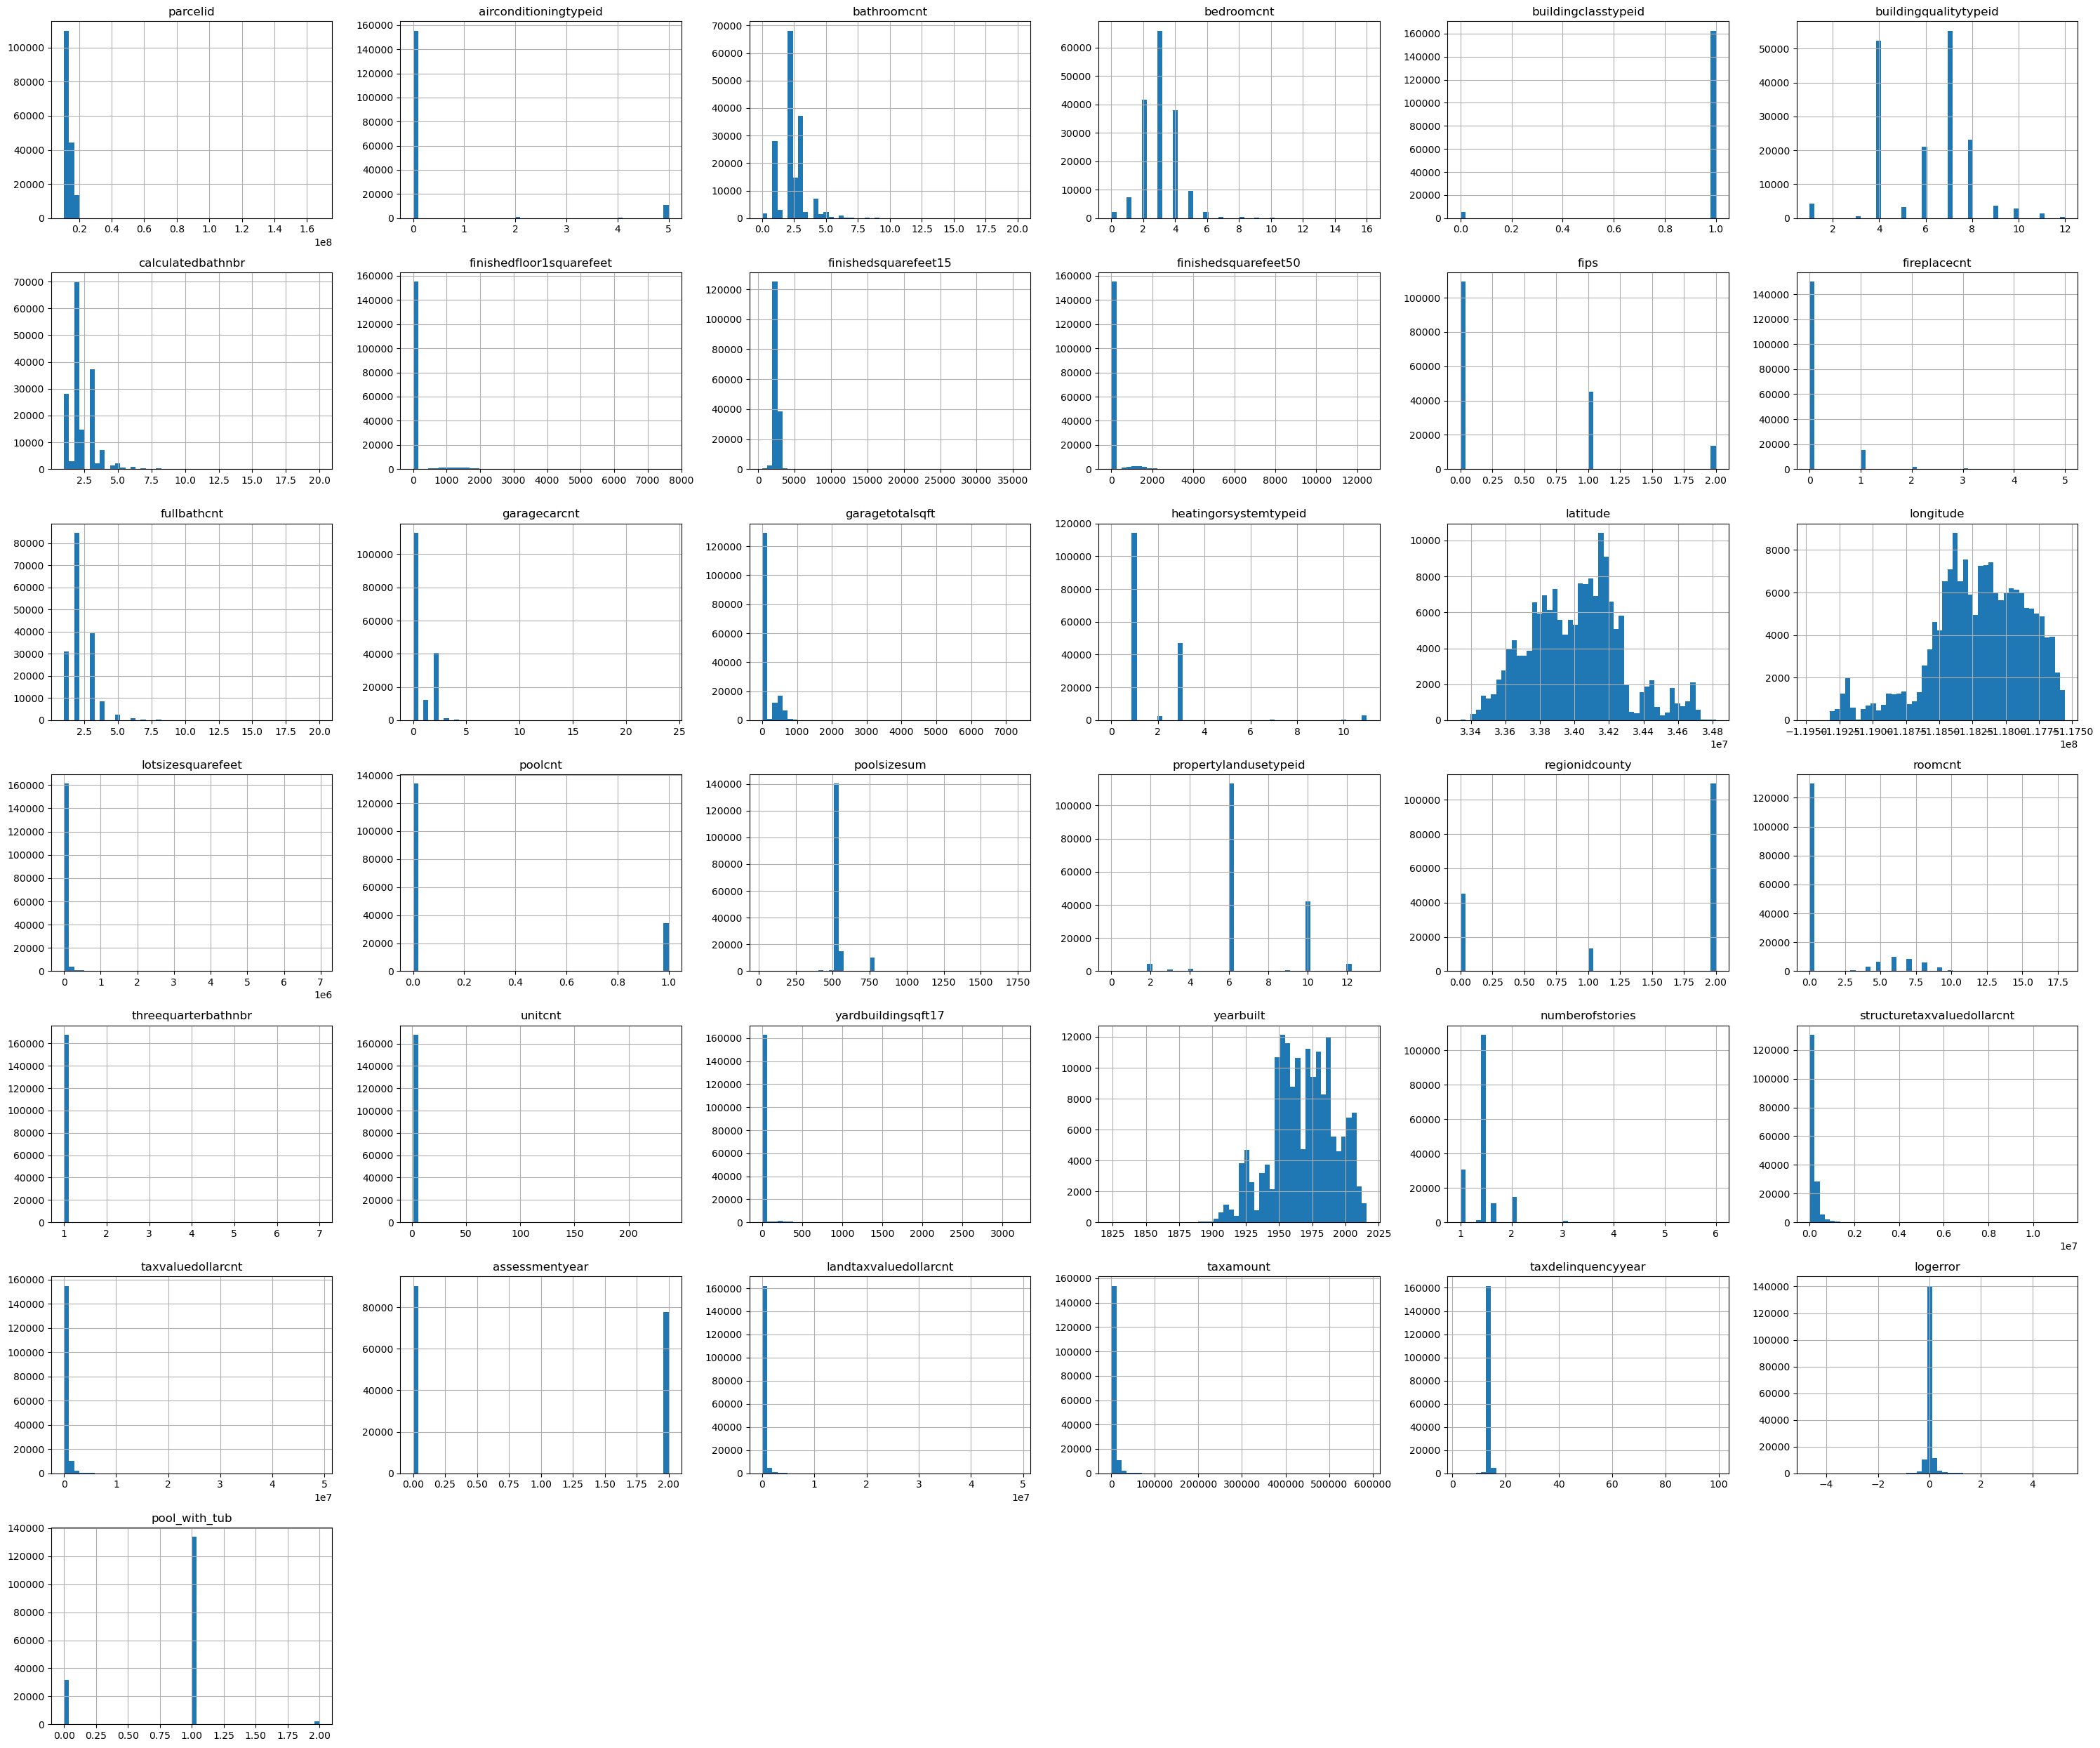

In [422]:
df.hist(bins=50, figsize=(30,25))
plt.tight_layout()

<AxesSubplot: >

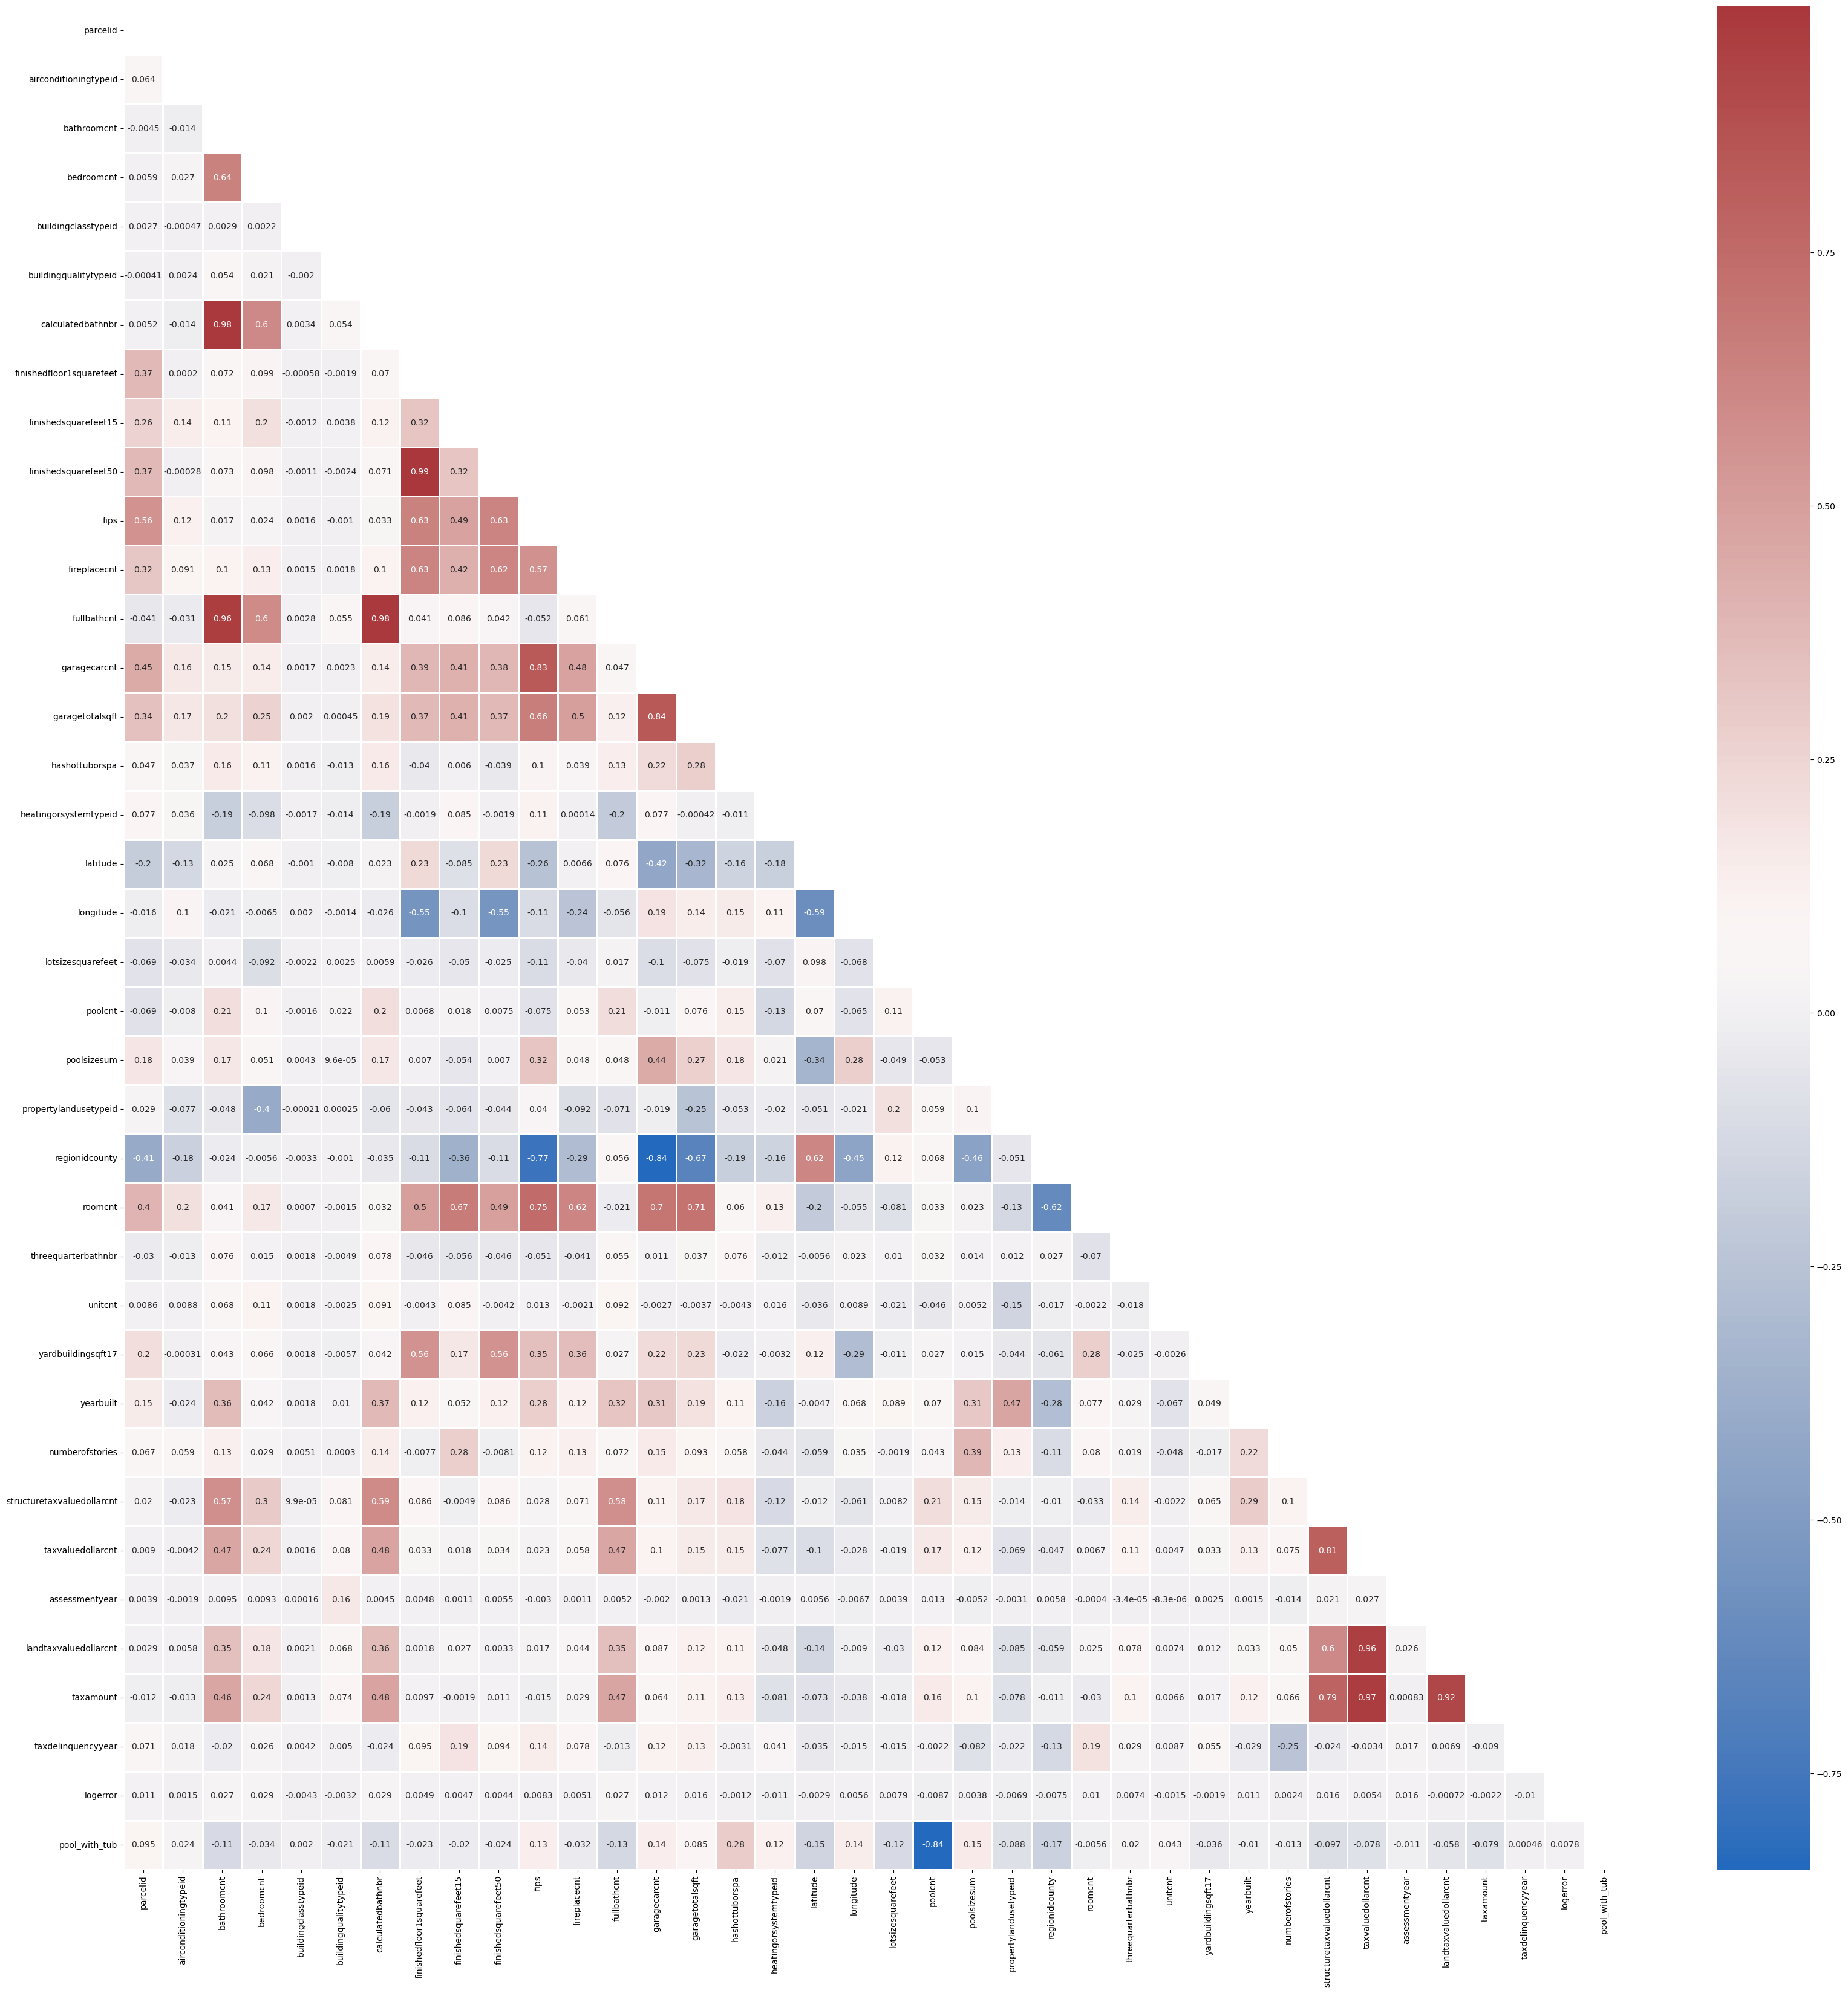

In [423]:
plt.figure(figsize = (40,40))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot=True, linewidths=1.0, cmap='vlag', mask=mask)

/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

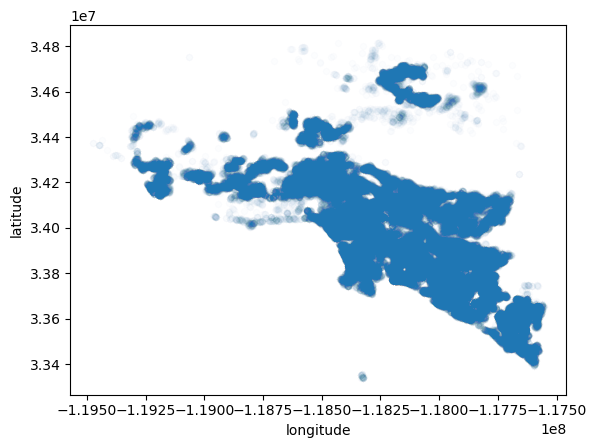

In [170]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.01)

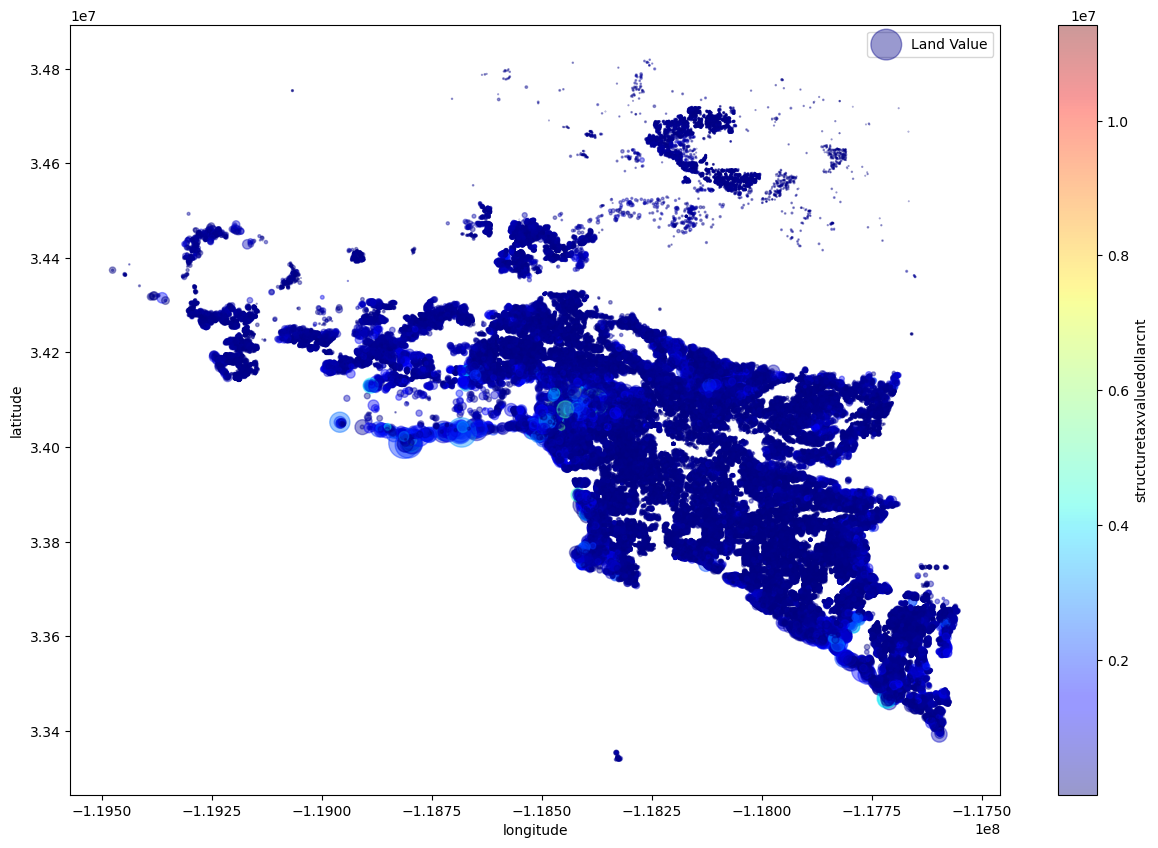

In [171]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=df["landtaxvaluedollarcnt"]/50000, label="Land Value", figsize=(15,10),
             c="structuretaxvaluedollarcnt", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

## Data Preprocessing

In [469]:
# read in cleaned data
all = pd.read_csv("data/cleaned_data.csv")
all.head()

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,finishedsquarefeet15,finishedsquarefeet50,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,pool_with_tub
0,17073783,5,2.5,3,1,8,2.5,548,3199.666667,548,...,191811,0,76724,2015.06,0,13.666667,6.110000e+13,0.0953,1/27/16,1
1,17088994,0,1.0,2,1,4,1.0,777,2731.000000,777,...,239679,0,95870,2581.30,0,14.333333,6.110000e+13,0.0198,3/30/16,1
2,17100444,0,2.0,3,1,4,2.0,1101,2731.000000,1101,...,47853,0,14234,591.64,0,14.333333,6.110000e+13,0.0060,5/27/16,1
3,17102429,0,1.5,2,1,6,1.5,1554,2731.000000,1554,...,62914,0,17305,682.78,0,14.333333,6.110000e+13,-0.0566,6/7/16,1
4,17109604,0,2.5,4,1,7,2.5,1305,3199.666667,1305,...,554000,0,277000,5886.92,0,13.666667,6.110000e+13,0.0573,8/8/16,1


In [470]:
# Perform Categorical encoding
for column in ('fips','airconditioningtypeid','buildingclasstypeid','regionidcounty','assessmentyear','pool_with_tub','heatingorsystemtypeid','propertylandusetypeid'):
  all[column] = pd.Categorical(all[column]).codes
all.head()

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,finishedsquarefeet15,finishedsquarefeet50,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,pool_with_tub
0,17073783,5,2.5,3,1,8,2.5,548,3199.666667,548,...,191811,0,76724,2015.06,0,13.666667,6.110000e+13,0.0953,1/27/16,1
1,17088994,0,1.0,2,1,4,1.0,777,2731.000000,777,...,239679,0,95870,2581.30,0,14.333333,6.110000e+13,0.0198,3/30/16,1
2,17100444,0,2.0,3,1,4,2.0,1101,2731.000000,1101,...,47853,0,14234,591.64,0,14.333333,6.110000e+13,0.0060,5/27/16,1
3,17102429,0,1.5,2,1,6,1.5,1554,2731.000000,1554,...,62914,0,17305,682.78,0,14.333333,6.110000e+13,-0.0566,6/7/16,1
4,17109604,0,2.5,4,1,7,2.5,1305,3199.666667,1305,...,554000,0,277000,5886.92,0,13.666667,6.110000e+13,0.0573,8/8/16,1


In [471]:
many_categories_col = []
for col in df.columns:
    # If the column is of category
    if df[col].dtype == 'category':
        many_categories_col.append(col)
        # Print the count of unique categories in the column
        print(f"Column {col} has {df[col].nunique()} unique categories:")
# These columns have too many categories which i'm dropping first to reduce our feature and decrease model fitting time, 
# would depend on the performance of the model to see whether to add them back. 
print(many_categories_col)

Column propertycountylandusecode has 88 unique categories:
Column propertyzoningdesc has 2346 unique categories:
Column rawcensustractandblock has 3223 unique categories:
Column regionidcity has 178 unique categories:
Column regionidneighborhood has 505 unique categories:
Column regionidzip has 390 unique categories:
Column censustractandblock has 60 unique categories:
['propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'censustractandblock']


In [472]:
#Drop columns with too many categories first and add them back if the model performs bad.
all = all.drop(many_categories_col, axis=1)

In [486]:
""" from sklearn.preprocessing import LabelEncoder
non_numeric = all.select_dtypes(exclude=[int, float])
# apply label encoding to non-numeric columns
le = LabelEncoder()
all[non_numeric.columns] = non_numeric.apply(le.fit_transform) """

' from sklearn.preprocessing import LabelEncoder\nnon_numeric = all.select_dtypes(exclude=[int, float])\n# apply label encoding to non-numeric columns\nle = LabelEncoder()\nall[non_numeric.columns] = non_numeric.apply(le.fit_transform) '

## Splitting Training and Testing Data

In [474]:
all.shape

(167888, 40)

In [475]:
y = all['logerror'].values.reshape(-1, 1).ravel()
X = all.drop(columns=['parcelid', 'logerror','transactiondate'], axis=1)

In [476]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.51, random_state=7)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(82265, 37)
(85623, 37)
(82265,)
(85623,)


## Fitting Model

In [478]:
# Check if all columns are continuous
num_continuous_cols = len(all.select_dtypes(include=['float64', 'int64']).columns)
if num_continuous_cols == len(all.columns):
    print("All columns are continuous")
else:
    print("Not all columns are continuous")

All columns are continuous


In [479]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf = RandomForestRegressor(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# calculate mean squared error of predictions
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error: ", mae)

Mean absolute error:  0.069055132835259


In [480]:
from sklearn.svm import SVR

svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mean_absolute_error(y_test, y_pred))

Mean absolute error: 0.09278202299382934


In [481]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 3, 4, 5],
    'learning_rate':[0.01, 0.1, 1],
    'loss': ['ls', 'lad', 'huber']
}

gbr = GradientBoostingRegressor(random_state=0)

grid_search = GridSearchCV(gbr, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 570, in _validate_params
    validate_parameter_cons

Best hyperparameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5, 'n_estimators': 50}
Mean Absolute Error: 0.06821779304622592


### Tune Parameters for Random Forest

In [482]:

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# make predictions on test set using best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# calculate mean squared error of predictions
mae = (y_test, y_pred)
print("Mean absolute error: ", mae)

# print best parameters found by grid search
print("Best parameters: ", grid_search.best_params_)

Mean absolute error:  (array([ 0.3221    ,  0.01      , -0.004     , ...,  0.0227    ,
        0.04233529, -0.0576    ]), array([0.00734251, 0.01342464, 0.0159855 , ..., 0.01213336, 0.01070051,
       0.00803447]))
Best parameters:  {'max_depth': 5, 'n_estimators': 150}


### Feature importance from the Random Forest Model

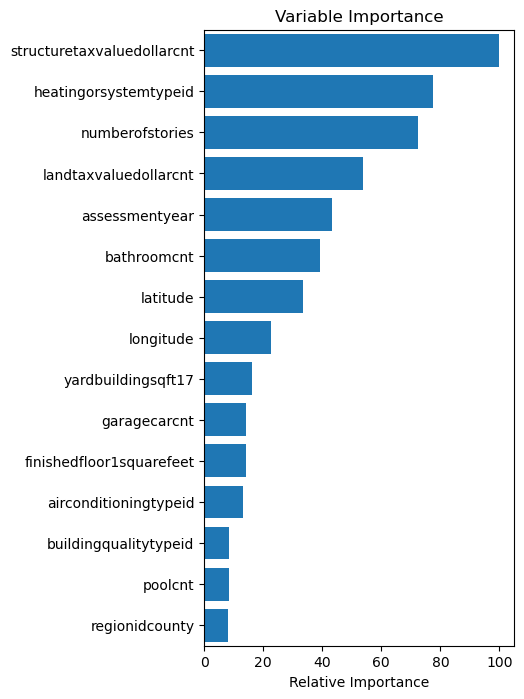

In [483]:
def plot_feat_imp(sk_model, feat_names, N_feature):
    
    feature_importance = sk_model.feature_importances_
    feature_importance = 100.0 * feature_importance / feature_importance.max()
    sorted_idx = np.argsort(feature_importance)
    total_features = sorted_idx.shape[0]
    pos = np.arange(total_features) + .5
    
    fig, ax = plt.subplots(figsize=(4,8))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(fnames[sorted_idx])
    ax.set_ylim(total_features-N_feature, total_features)
    ax.set_xlabel('Relative Importance')
   
    plt.title('Variable Importance')
    plt.show()
    
fnames = all.columns
plot_feat_imp(rf, fnames, 15)

### Feature Importance from the Gradient Boosting Regressor

In [487]:
from sklearn.inspection import permutation_importance

gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = 'huber', max_depth = 5, n_estimators = 50)
gbr.fit(X_train, y_train)

result = permutation_importance(gbr, X_test, y_test, n_repeats=10, random_state=0)


importance_scores = result.importances_mean
print("Feature importance scores: ", importance_scores)
""" # Print the feature importances
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}") """

Feature importance scores:  [ 1.16170625e-06  7.27382491e-04  1.45165382e-03  3.14052864e-07
 -8.09310138e-05  3.84709046e-04  9.42622120e-05 -2.28459954e-04
  9.81706423e-06 -6.55766467e-07  0.00000000e+00  1.54913073e-05
  2.69106586e-06  1.82056562e-05  1.95420788e-06  3.68623695e-05
  8.31353944e-04  2.74517912e-03  6.92886114e-04  8.64658071e-04
  2.33827124e-05  5.05914744e-04 -1.25683668e-05 -2.91345404e-06
  4.58977910e-05  1.92578536e-04  1.12889056e-04  1.59179691e-03
  2.29603548e-05  2.51196086e-04  2.28804957e-03 -2.08242635e-06
  2.09886760e-03  1.13006351e-02  1.87197124e-04  2.20433047e-04
  4.11180844e-05]


' # Print the feature importances\nfor i in result.importances_mean.argsort()[::-1]:\n    print(f"{X.columns[i]:<8}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}") '

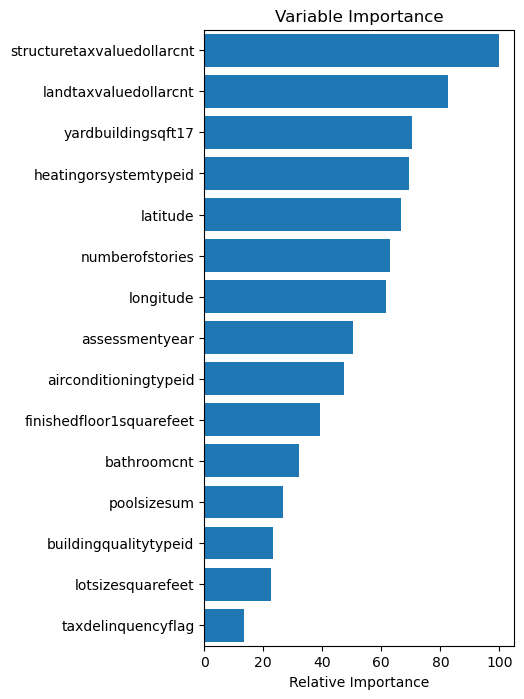

In [488]:
fnames = all.columns
plot_feat_imp(gbr, fnames, 15)

In [489]:
importance_scores = result.importances_mean

top_k = [10, 15, 20]
for i in top_k:
    top_k_idx = np.argsort(importance_scores)[-i:]
    # Select the top-k most important features
    X_train_top_k = X_train.iloc[:, top_k_idx]
    X_test_top_k = X_test.iloc[:, top_k_idx]

    # Train a new model on the selected features
    gbr_top_k = GradientBoostingRegressor(learning_rate = 0.1, loss = 'huber', max_depth = 5, n_estimators = 50)
    gbr_top_k.fit(X_train_top_k, y_train)

    y_pred_top_k = gbr_top_k.predict(X_test_top_k)
    mae = mean_absolute_error(y_test, y_pred_top_k)
    print(f"Mean absolute error for top {i} features: ", mae)

Mean absolute error for top 10 features:  0.06825119219076739
Mean absolute error for top 15 features:  0.06824795883805523
Mean absolute error for top 20 features:  0.06820694154883676


### Permutation_importance for feature selection

In [493]:

rf_model = RandomForestRegressor(n_estimators=150, max_depth=5)
rf_model.fit(X_train, y_train)

# calculate feature importances using permutation importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

# print feature importance scores
importance_scores = result.importances_mean
print("Feature importance scores: ", importance_scores)

Feature importance scores:  [-6.44513323e-06  2.68161159e-04  9.87045472e-04 -4.39914310e-06
 -4.11932286e-06  2.67806903e-04  5.11652934e-05 -7.03527677e-05
  3.10822127e-05  4.16421497e-06 -4.24672600e-06 -3.99919224e-05
 -1.09547928e-06  4.01371311e-05  0.00000000e+00 -2.01073715e-05
  1.56743236e-05 -4.14358933e-04  2.90959245e-04  8.03062667e-05
  8.73690791e-06  6.27226410e-06  2.49944303e-05 -5.43630508e-05
  1.93255282e-04  4.59483513e-05  1.24428127e-04  8.95605896e-04
  1.00882338e-05  2.29078402e-03  3.35938399e-03  4.22815850e-06
  5.20004880e-05  4.09954707e-03  2.86645781e-06  6.41920531e-05
  3.18394526e-05]


In [494]:
importance_scores = result.importances_mean

top_k = [10, 15, 20]
for i in top_k:
    top_k_idx = np.argsort(importance_scores)[-i:]
    # Select the top-k most important features
    X_train_top_k = X_train.iloc[:, top_k_idx]
    X_test_top_k = X_test.iloc[:, top_k_idx]

    # Train a new model on the selected features
    rf_top_k = RandomForestRegressor(n_estimators=150, max_depth=5)
    rf_top_k.fit(X_train_top_k, y_train)

    y_pred_top_k = rf_top_k.predict(X_test_top_k)
    mae = mean_absolute_error(y_test, y_pred_top_k)
    print(f"Mean absolute error for top {i} features: ", mae)

Mean absolute error for top 10 features:  0.06901743074350257
Mean absolute error for top 15 features:  0.06901686832162332
Mean absolute error for top 20 features:  0.06904283894868797


### Write model to pickle

In [492]:
import pickle

with open('zestimator_model.pkl', 'wb') as file:
    pickle.dump(gbr, file)